In [27]:
from __future__ import print_function
import argparse
import numpy as np
import os
import shutil
import time
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import pickle
from benedict import BeneDict
import copy
import seaborn as sns
from scipy.stats.stats import pearsonr
from scipy.stats import linregress
plt.style.use('seaborn')
plt.style.use('seaborn-talk')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Custom code
import utils as U
from generate_graph_structure import create_adjacency_matrix, flatten_correlation, granger_causality, behavioral_prediction_correlation_wrapper
from dataloading import read_from_files, filter_data, normalize_by_behavior_report_type

In [29]:
savenames = ['BAYLORGC4_2018_03_20.mat',
             'BAYLORGC4_2018_03_21.mat',
             'BAYLORGC4_2018_03_22.mat',
             'BAYLORGC4_2018_03_23.mat',
             'BAYLORGC4_2018_03_25.mat',
             'BAYLORGC12_2018_04_03.mat',
             'BAYLORGC12_2018_04_04.mat',
             'BAYLORGC12_2018_04_05.mat',
             'BAYLORGC12_2018_04_06.mat',
             'BAYLORGC13_2018_04_23.mat',
             'BAYLORGC13_2018_04_24.mat',
             'BAYLORGC13_2018_04_25.mat',
             'BAYLORGC15_2018_05_07.mat',
             'BAYLORGC15_2018_05_08.mat',
             'BAYLORGC15_2018_05_09.mat',
             'BAYLORGC15_2018_05_10.mat',
             'BAYLORGC15_2018_05_11.mat',
             'BAYLORGC17_2018_06_08.mat',
             'BAYLORGC17_2018_06_11.mat',
             'BAYLORGC18_2018_05_31.mat',
             'BAYLORGC19_2018_06_20.mat',
             'BAYLORGC19_2018_06_21.mat',
             'BAYLORGC19_2018_06_22.mat'
            ]
# !!!!! Change here to generate graphs for different sessions
all_file_to_read = [savenames[0]]
print('Reading files {}'.format(', '.join(all_file_to_read)))
all_data = read_from_files(all_file_to_read)

Reading files BAYLORGC4_2018_03_20.mat


In [30]:
# !!!!! Change here to generate graphs for different perturbation conditions

# The type of perturbation enforced
## 0: no 
## 1: perturbation of left
## 2: perturbation of right
## 3: perturbation of both
perturbation_type = 3 # or 1, 2, or 3


# Only look at success trials when True
# When there is bilarteral perturbation, the mice cannot act correctly, so we need to look at unsuccessful trials
enforce_task_success = (perturbation_type != 3)
# When there is no perturbation
if perturbation_type == 0:
    time_window = (22,37)
else:
# when there are perturbations, we use neural signals after the perturbations have ended
    time_window = (31,37)

In [31]:
## Filter all the data depending on what we want
all_data_filtered = [filter_data(data,
                                 perturbation_type=perturbation_type,
                                 enforce_task_success=enforce_task_success,
                                 time_window=time_window) for data in all_data]

if perturbation_type != 3:
    all_data_filtered = [normalize_by_behavior_report_type(data) for data in all_data_filtered]

N, T, K:  42 6 84
(84,)
shape (84, 84)
data [[ 0.          0.07888414 -0.02231537 ...  0.1718256   0.17513485
  -0.07255093]
 [ 0.07888414  0.          0.05595667 ...  0.26198229 -0.22962061
   0.08902678]
 [-0.02231537  0.05595667  0.         ...  0.06310165  0.12386642
   0.01904184]
 ...
 [ 0.1718256   0.26198229  0.06310165 ...  0.         -0.12895877
   0.22749555]
 [ 0.17513485 -0.22962061  0.12386642 ... -0.12895877  0.
   0.06886092]
 [-0.07255093  0.08902678  0.01904184 ...  0.22749555  0.06886092
   0.        ]]


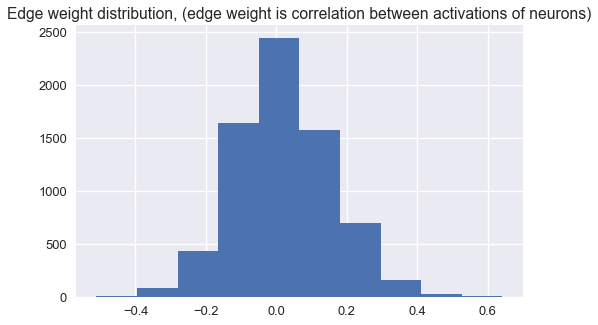

In [32]:
## Generates a graph using correlation
mat_correlation = create_adjacency_matrix(all_data_filtered[0], edge_weight_func=flatten_correlation)
## !! Symmetric
print('shape', mat_correlation.shape)
print('data', mat_correlation)
f = plt.figure()
plt.hist(mat_correlation.flatten())
plt.title('Edge weight distribution, (edge weight is correlation between activations of neurons)')
f.set_size_inches(8,5)
plt.show()

N, T, K:  42 6 84
(84,)
shape (84, 84)
data [[0.         0.98275389 0.         ... 0.86967538 0.51625097 0.79833324]
 [0.3427866  0.         0.20232229 ... 0.68931543 0.66371651 0.78777128]
 [0.09548716 0.99022383 0.         ... 0.66367847 0.82519619 0.31374427]
 ...
 [0.34919823 0.79522843 0.53291331 ... 0.         0.90028832 0.98624912]
 [0.92969339 0.2247122  0.59520166 ... 0.04972979 0.         0.1128367 ]
 [0.37045902 0.18743744 0.         ... 0.49627979 0.89811012 0.        ]]


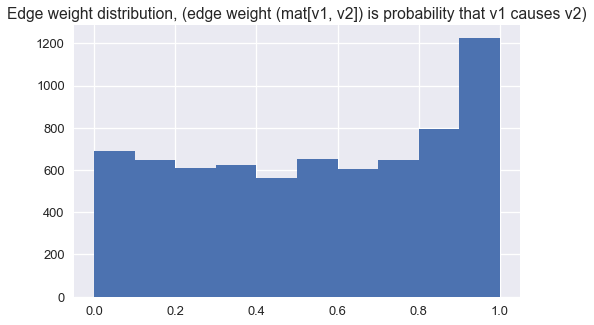

In [33]:
## Generates a graph using granger_causality
mat_granger = create_adjacency_matrix(all_data_filtered[0], edge_weight_func=granger_causality)
## !! Not symmetric
print('shape', mat_granger.shape)
print('data', mat_granger)
f = plt.figure()
plt.hist(mat_granger.flatten())
plt.title('Edge weight distribution, (edge weight (mat[v1, v2]) is probability that v1 causes v2)')
f.set_size_inches(8,5)
plt.show()

N, T, K:  42 6 84
(84,)
shape (84, 84)
data [[0.         0.64285714 1.         ... 1.         0.9047619  0.42857143]
 [0.64285714 0.         0.64285714 ... 0.64285714 0.54761905 0.5       ]
 [1.         0.64285714 0.         ... 1.         0.9047619  0.42857143]
 ...
 [1.         0.64285714 1.         ... 0.         0.9047619  0.42857143]
 [0.9047619  0.54761905 0.9047619  ... 0.9047619  0.         0.38095238]
 [0.42857143 0.5        0.42857143 ... 0.42857143 0.38095238 0.        ]]


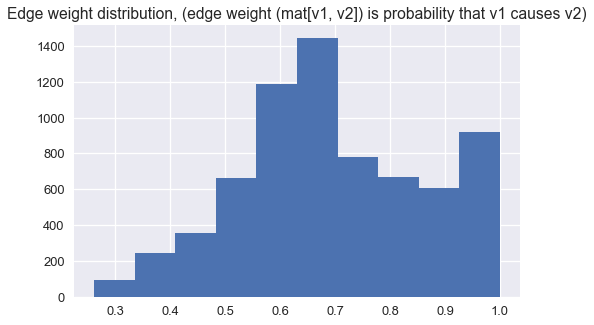

In [34]:
## Generates a graph using granger_causality
mat_behav_pred = create_adjacency_matrix(all_data_filtered[0], edge_weight_func=behavioral_prediction_correlation_wrapper(all_data_filtered[0]['behavior_report_type']))
## symmetric
print('shape', mat_behav_pred.shape)
print('data', mat_behav_pred)
f = plt.figure()
connections = []
for a in range(mat_behav_pred.shape[0]):
    for b in range(mat_behav_pred.shape[1]):
        if a != b:
            connections.append(mat_behav_pred[a, b])
connections = np.array(connections)
plt.hist(connections)
plt.title('Edge weight distribution, (edge weight (mat[v1, v2]) is probability that v1 causes v2)')
f.set_size_inches(8,5)
plt.show()

In [35]:
print(mat_behav_pred)

[[0.         0.64285714 1.         ... 1.         0.9047619  0.42857143]
 [0.64285714 0.         0.64285714 ... 0.64285714 0.54761905 0.5       ]
 [1.         0.64285714 0.         ... 1.         0.9047619  0.42857143]
 ...
 [1.         0.64285714 1.         ... 0.         0.9047619  0.42857143]
 [0.9047619  0.54761905 0.9047619  ... 0.9047619  0.         0.38095238]
 [0.42857143 0.5        0.42857143 ... 0.42857143 0.38095238 0.        ]]
